In [21]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.layers import LSTM, Convolution1D, Flatten, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import re

In [2]:
path = "/Users/kia/Desktop/SYS 6016/Final project/"
file = "yelp_review.csv"
df = pd.read_csv(path+file,usecols = ["stars","text"])
df.shape

(5261668, 2)

In [3]:
df.isnull().sum()

stars    0
text     0
dtype: int64

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


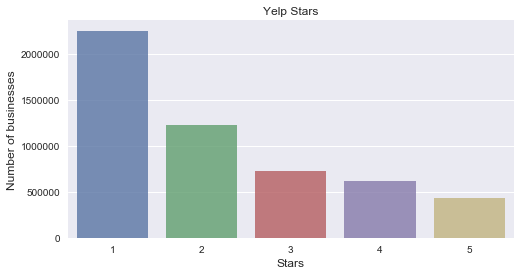

In [4]:
x = df['stars'].value_counts()
y = x.sort_index()

plt.figure(figsize=(8,4))
ax= sns.barplot(y.index, x.values, alpha=0.8)
plt.title("Yelp Stars")
plt.ylabel('Number of businesses', fontsize=12)
plt.xlabel('Stars', fontsize=12)

# Create a binary label

* 4 & 5 = positive
* 1 & 2 = negative
* Remove 3 since it is neutral

In [5]:
df = df[df['stars']!=3]

In [6]:
df["label"] = df["stars"].apply(lambda x: 1 if x > 3  else 0)
label_df = df.drop("stars",axis=1)

label_df.head()

,text,label
0,Super simple place but amazing nonetheless. It...,1
1,Small unassuming place that changes their menu...,1
2,Lester's is located in a beautiful neighborhoo...,1
3,Love coming here. Yes the place always needs t...,1
4,Had their chocolate almond croissant and it wa...,1


In [7]:
label_df['label'].value_counts()

1    3476663
0    1169524
Name: label, dtype: int64

# Downsample to the minority class with ratio 1:1

In [14]:
balance_df = label_df.groupby('label')
subset_df = balance_df.apply(lambda x: x.sample(50000,random_state=42).reset_index(drop=True))
subset_df['label'].value_counts()

1    50000
0    50000
Name: label, dtype: int64

# Tokenize the text

In [26]:
text = subset_df["text"].values
label = subset_df["label"].values

In [29]:
MAX_NUM_WORDS=1000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH=100 # max number of words in a review to use


tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

sequence_encodings = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

label = keras.utils.to_categorical(np.asarray(label))
print('Shape of sequence encodings tensor:', sequence_encodings.shape)
print('Shape of label tensor:', label.shape)

Found 100331 unique tokens.
Shape of sequence encodings tensor: (100000, 100)
Shape of label tensor: (100000, 2, 2)


# Split data into training and testing

In [30]:
# Split data into 70% training and 30% testing
train_size = int(len(sequence_encodings) * 0.7)
test_size = len(sequence_encodings) - train_size
data_train = sequence_encodings[0:train_size]
data_test = sequence_encodings[train_size:len(sequence_encodings)]
print("Training: %i , Testing: %i"%(len(data_train), len(data_test)))

Training: 70000 , Testing: 30000
